# Compare ablation area

Author: Ziqi Yin

Last modified: 2024 Feb 18

Table of contents:
* [Annual mean ablation area vs ELA(t)](#first-bullet)

In [1]:
import numpy as np
import numpy.ma as ma
import xarray as xr
from statistics import mode
import pandas as pd
from scipy import signal
from scipy import interpolate
from scipy import stats
import scipy.sparse as sps # For reading weight files
from math import radians, sin, cos, sqrt, atan2

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.colors as colors
from matplotlib.collections import PolyCollection
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import cartopy
import cartopy.crs as ccrs
crs_np = ccrs.NorthPolarStereo(central_longitude=0)
crs_ll = ccrs.PlateCarree()
from cartopy.util import add_cyclic_point
from holoviews.operation.datashader import datashade, rasterize, regrid

home_dir = '/glade/work/ziqiyin/'
import sys  
sys.path.insert(0, home_dir)
sys.path.append(home_dir + 'function/')
from functions import *

import warnings
warnings.filterwarnings('ignore')

# For regridding
import os
import ESMF
import xesmf as xe

In [2]:
## Parameter
g = 9.80616 #[m/s2]

## 1. Annual mean ablation area vs ELA(t)<a class="anchor" id="first-bullet"></a>

### Get data

In [3]:
## f09muntjewerf
# 1pctCO2
f09_1pctCO2_RAIN_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_RAIN_1pctCO2_yearly.nc')['RAIN'][:140]
f09_1pctCO2_SNOW_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_SNOW_1pctCO2_yearly.nc')['SNOW'][:140]
f09_1pctCO2_QICE_MELT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_QICE_MELT_1pctCO2_yearly.nc')['QICE_MELT'][:140]
f09_1pctCO2_QSNOMELT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_QSNOMELT_1pctCO2_yearly.nc')['QSNOMELT'][:140]
f09_1pctCO2_QFLX_EVAP_TOT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_QFLX_EVAP_TOT_1pctCO2_yearly.nc')['QFLX_EVAP_TOT'][:140]
f09_1pctCO2_QRUNOFF_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_QRUNOFF_1pctCO2_yearly.nc')['QRUNOFF'][:140]
f09_1pctCO2_PHIS_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_PHIS_1pctCO2_JJA_yearly.nc')['PHIS'][:140]
f09_lon = f09_1pctCO2_RAIN_yearly.lon
f09_lat = f09_1pctCO2_RAIN_yearly.lat

# 4xCO2
f09_4xext_RAIN_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_RAIN_4xext_yearly.nc')['RAIN']
f09_4xext_SNOW_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_SNOW_4xext_yearly.nc')['SNOW']
f09_4xext_QICE_MELT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_QICE_MELT_4xext_yearly.nc')['QICE_MELT']
f09_4xext_QSNOMELT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_QSNOMELT_4xext_yearly.nc')['QSNOMELT']
f09_4xext_QFLX_EVAP_TOT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_QFLX_EVAP_TOT_4xext_yearly.nc')['QFLX_EVAP_TOT']
f09_4xext_QRUNOFF_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_QRUNOFF_4xext_yearly.nc')['QRUNOFF']
f09_4xext_PHIS_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_PHIS_4xext_JJA_yearly.nc')['PHIS']

# Combine
f09_1pctCO2_4xext_RAIN_yearly = xr.concat([f09_1pctCO2_RAIN_yearly, f09_4xext_RAIN_yearly], dim='time')
f09_1pctCO2_4xext_SNOW_yearly = xr.concat([f09_1pctCO2_SNOW_yearly, f09_4xext_SNOW_yearly], dim='time')
f09_1pctCO2_4xext_QICE_MELT_yearly = xr.concat([f09_1pctCO2_QICE_MELT_yearly, f09_4xext_QICE_MELT_yearly], dim='time')
f09_1pctCO2_4xext_QSNOMELT_yearly = xr.concat([f09_1pctCO2_QSNOMELT_yearly, f09_4xext_QSNOMELT_yearly], dim='time')
f09_1pctCO2_4xext_QFLX_EVAP_TOT_yearly = xr.concat([f09_1pctCO2_QFLX_EVAP_TOT_yearly, f09_4xext_QFLX_EVAP_TOT_yearly], dim='time')
f09_1pctCO2_4xext_QRUNOFF_yearly = xr.concat([f09_1pctCO2_QRUNOFF_yearly, f09_4xext_QRUNOFF_yearly], dim='time')
f09_1pctCO2_4xext_PHIS_yearly = xr.concat([f09_1pctCO2_PHIS_yearly, f09_4xext_PHIS_yearly], dim='time')

In [4]:
## f09nohacks
# 1pctCO2
f09_nohacks_1pctCO2_RAIN_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_RAIN_1pctCO2_yearly.nc')['RAIN'][:]
f09_nohacks_1pctCO2_SNOW_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_SNOW_1pctCO2_yearly.nc')['SNOW'][:]
f09_nohacks_1pctCO2_QICE_MELT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_QICE_MELT_1pctCO2_yearly.nc')['QICE_MELT'][:]
f09_nohacks_1pctCO2_QSNOMELT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_QSNOMELT_1pctCO2_yearly.nc')['QSNOMELT'][:]
f09_nohacks_1pctCO2_QFLX_EVAP_TOT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_QFLX_EVAP_TOT_1pctCO2_yearly.nc')['QFLX_EVAP_TOT'][:]
f09_nohacks_1pctCO2_QRUNOFF_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_QRUNOFF_1pctCO2_yearly.nc')['QRUNOFF'][:]
f09_nohacks_1pctCO2_PHIS_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_PHIS_1pctCO2_JJA_yearly.nc')['PHIS']

# 4xext
f09_nohacks_4xext_RAIN_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_RAIN_4xext_yearly.nc')['RAIN'][:]
f09_nohacks_4xext_SNOW_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_SNOW_4xext_yearly.nc')['SNOW'][:]
f09_nohacks_4xext_QICE_MELT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_QICE_MELT_4xext_yearly.nc')['QICE_MELT'][:]
f09_nohacks_4xext_QSNOMELT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_QSNOMELT_4xext_yearly.nc')['QSNOMELT'][:]
f09_nohacks_4xext_QFLX_EVAP_TOT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_QFLX_EVAP_TOT_4xext_yearly.nc')['QFLX_EVAP_TOT'][:]
f09_nohacks_4xext_QRUNOFF_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_QRUNOFF_4xext_yearly.nc')['QRUNOFF'][:]
f09_nohacks_4xext_PHIS_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_PHIS_4xext_JJA_yearly.nc')['PHIS']

# Combine
f09_nohacks_1pctCO2_4xext_RAIN_yearly = xr.concat([f09_nohacks_1pctCO2_RAIN_yearly, f09_nohacks_4xext_RAIN_yearly], dim='time')
f09_nohacks_1pctCO2_4xext_SNOW_yearly = xr.concat([f09_nohacks_1pctCO2_SNOW_yearly, f09_nohacks_4xext_SNOW_yearly], dim='time')
f09_nohacks_1pctCO2_4xext_QICE_MELT_yearly = xr.concat([f09_nohacks_1pctCO2_QICE_MELT_yearly, f09_nohacks_4xext_QICE_MELT_yearly], dim='time')
f09_nohacks_1pctCO2_4xext_QSNOMELT_yearly = xr.concat([f09_nohacks_1pctCO2_QSNOMELT_yearly, f09_nohacks_4xext_QSNOMELT_yearly], dim='time')
f09_nohacks_1pctCO2_4xext_QFLX_EVAP_TOT_yearly = xr.concat([f09_nohacks_1pctCO2_QFLX_EVAP_TOT_yearly, f09_nohacks_4xext_QFLX_EVAP_TOT_yearly], dim='time')
f09_nohacks_1pctCO2_4xext_QRUNOFF_yearly = xr.concat([f09_nohacks_1pctCO2_QRUNOFF_yearly, f09_nohacks_4xext_QRUNOFF_yearly], dim='time')
f09_nohacks_1pctCO2_4xext_PHIS_yearly = xr.concat([f09_nohacks_1pctCO2_PHIS_yearly, f09_nohacks_4xext_PHIS_yearly], dim='time')

In [5]:
## ARCTIC
# 1pctCO2
ARCTIC_1pctCO2_RAIN_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_RAIN_1pctCO2_yearly.nc')['RAIN'] 
ARCTIC_1pctCO2_SNOW_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_SNOW_1pctCO2_yearly.nc')['SNOW'] 
ARCTIC_1pctCO2_QICE_MELT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_QICE_MELT_1pctCO2_yearly.nc')['QICE_MELT'] 
ARCTIC_1pctCO2_QSNOMELT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_QSNOMELT_1pctCO2_yearly.nc')['QSNOMELT']
ARCTIC_1pctCO2_QFLX_EVAP_TOT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_QFLX_EVAP_TOT_1pctCO2_yearly.nc')['QFLX_EVAP_TOT']
ARCTIC_1pctCO2_QRUNOFF_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_QRUNOFF_1pctCO2_yearly.nc')['QRUNOFF']
ARCTIC_1pctCO2_PHIS_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_PHIS_1pctCO2_JJA_yearly.nc')['PHIS']
ARCTIC_lon = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_lon.nc')['lon']
ARCTIC_lat = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_lat.nc')['lat']

# 4xext
ARCTIC_4xext_RAIN_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_RAIN_4xext_yearly.nc')['RAIN']
ARCTIC_4xext_SNOW_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_SNOW_4xext_yearly.nc')['SNOW']
ARCTIC_4xext_QICE_MELT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_QICE_MELT_4xext_yearly.nc')['QICE_MELT']
ARCTIC_4xext_QSNOMELT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_QSNOMELT_4xext_yearly.nc')['QSNOMELT']
ARCTIC_4xext_QFLX_EVAP_TOT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_QFLX_EVAP_TOT_4xext_yearly.nc')['QFLX_EVAP_TOT']
ARCTIC_4xext_QRUNOFF_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_QRUNOFF_4xext_yearly.nc')['QRUNOFF']
ARCTIC_4xext_PHIS_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_PHIS_4xext_JJA_yearly.nc')['PHIS']

# Combine
ARCTIC_1pctCO2_4xext_RAIN_yearly = xr.concat([ARCTIC_1pctCO2_RAIN_yearly, ARCTIC_4xext_RAIN_yearly], dim='time')
ARCTIC_1pctCO2_4xext_SNOW_yearly = xr.concat([ARCTIC_1pctCO2_SNOW_yearly, ARCTIC_4xext_SNOW_yearly], dim='time')
ARCTIC_1pctCO2_4xext_QICE_MELT_yearly = xr.concat([ARCTIC_1pctCO2_QICE_MELT_yearly, ARCTIC_4xext_QICE_MELT_yearly], dim='time')
ARCTIC_1pctCO2_4xext_QSNOMELT_yearly = xr.concat([ARCTIC_1pctCO2_QSNOMELT_yearly, ARCTIC_4xext_QSNOMELT_yearly], dim='time')
ARCTIC_1pctCO2_4xext_QFLX_EVAP_TOT_yearly = xr.concat([ARCTIC_1pctCO2_QFLX_EVAP_TOT_yearly, ARCTIC_4xext_QFLX_EVAP_TOT_yearly], dim='time')
ARCTIC_1pctCO2_4xext_QRUNOFF_yearly = xr.concat([ARCTIC_1pctCO2_QRUNOFF_yearly, ARCTIC_4xext_QRUNOFF_yearly], dim='time')
ARCTIC_1pctCO2_4xext_PHIS_yearly = xr.concat([ARCTIC_1pctCO2_PHIS_yearly, ARCTIC_4xext_PHIS_yearly], dim='time')

#### Area

In [6]:
Re = 6371.22 * 1e3 #[m]

f09_mask_file3 = '/glade/p/cesmdata/cseg/inputdata/share/domains/domain.lnd.fv0.9x1.25_gx1v7.151020.nc'
f09_area = xr.open_dataset(f09_mask_file3)['area'] #[Radian2]
f09_area_Arctic = f09_area.where(f09_area.yc > 60).values * Re**2
f09_area = f09_area.values * Re**2
f09_ones = f09_nohacks_1pctCO2_4xext_PHIS_yearly[0,:,:] * 0 + 1
f09_area_coord = f09_ones * f09_area # grid area with lon,lat coordinates

ARCTIC_mask_file3 = '/glade/p/cesmdata/cseg/inputdata/share/domains/domain.lnd.ne0np4.ARCTIC.ne30x4_tx0.1v2.200626.nc'
ARCTIC_area = xr.open_dataset(ARCTIC_mask_file3)['area'] #[Radian2]
ARCTIC_area_Arctic = ARCTIC_area.where(ARCTIC_area.yc > 60).values * Re**2
ARCTIC_area = ARCTIC_area.values * Re**2
#ARCTIC_area = ARCTIC_area * Re**2
ARCTIC_ones = ARCTIC_1pctCO2_4xext_PHIS_yearly[0,:] * 0 + 1
ARCTIC_area_coord = ARCTIC_ones * ARCTIC_area.squeeze() # grid area with lon,lat coordinates

#### Mask

In [7]:
## Mask
# f09
# Generate Greenland mask
f09_mask_file1 = '/glade/work/aherring/grids/uniform-res/f09/clm_surfdata_5_0/surfdata_f09_hist_78pfts_CMIP6_simyr1850_c200429.nc'
f09_GrIS_mask0 = xr.open_dataset(f09_mask_file1)['GLACIER_REGION']
f09_GrIS_mask0 = xr.where(f09_GrIS_mask0==2, 1, np.nan)
# Glacier fraction of land area
f09_glacier_frac_piControl = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_PCT_LANDUNIT_piControl_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_mask_file2 = '/glade/campaign/cgd/amp/aherring/archive/cam6_2_022.se_FHIST_f09_f09_mg17_1800pes_200507_mg3-Nx5yrs/lnd/hist/cam6_2_022.se_FHIST_f09_f09_mg17_1800pes_200507_mg3-Nx5yrs.clm2.h0.1979-01.nc'
f09_glacier_frac_const = xr.open_dataset(f09_mask_file2)['PCT_LANDUNIT'][0,3,:,:] #ltype_landice_multiple_elevation_classes
f09_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:140,3,:,:]
f09_glacier_frac_4xext = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_glacier_frac = xr.concat([f09_glacier_frac_1pctCO2[:140], f09_glacier_frac_4xext], dim='time')
# Land fraction of grid cell
f09_mask_file3 = '/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/lnd/proc/tseries/month_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.RAIN.000101-005012.nc'
f09_land_frac = xr.open_dataset(f09_mask_file3)['landfrac'] #fraction of grid cell that is active
f09_GrIS_mask_piControl = f09_GrIS_mask0.values * f09_glacier_frac_piControl.values * f09_land_frac.values / 100
f09_GrIS_mask_const = f09_GrIS_mask0.values * f09_glacier_frac_const.values * f09_land_frac.values / 100
f09_GrIS_mask = f09_GrIS_mask0.values * f09_glacier_frac.values * f09_land_frac.values / 100

# f09nohacks
f09_nohacks_glacier_frac_piControl = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_piControl_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_GrIS_mask_piControl = f09_GrIS_mask0.values * f09_nohacks_glacier_frac_piControl.values * f09_land_frac.values / 100
f09_nohacks_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_glacier_frac_4xext = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_glacier_frac = xr.concat([f09_nohacks_glacier_frac_1pctCO2, f09_nohacks_glacier_frac_4xext], dim='time')
f09_nohacks_GrIS_mask = f09_GrIS_mask0.values * f09_nohacks_glacier_frac.values * f09_land_frac.values / 100

# BG7
BG7_glacier_frac = xr.open_dataset(home_dir+'dynamic_GrIS/BG7/BG7_PCT_LANDUNIT_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
BG7_GrIS_mask = f09_GrIS_mask0.values * BG7_glacier_frac.values * f09_land_frac.values / 100

# ARCTIC
# Generate Greenland mask
ARCTIC_mask_file1 = '/glade/work/aherring/grids/var-res/ne0np4.ARCTIC.ne30x4/clm_surfdata_5_0/surfdata_ne0np4.ARCTIC.ne30x4_hist_78pfts_CMIP6_simyr1850_c200426.nc'
ARCTIC_GrIS_mask0 = xr.open_dataset(ARCTIC_mask_file1)['GLACIER_REGION']
ARCTIC_GrIS_mask0 = xr.where(ARCTIC_GrIS_mask0==2, 1, np.nan)
# Glacier fraction of land area
ARCTIC_glacier_frac_piControl_p1 = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p1_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p2 = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p2_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p3 = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p3_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p4 = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p4_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl = xr.concat([ARCTIC_glacier_frac_piControl_p1, ARCTIC_glacier_frac_piControl_p2, ARCTIC_glacier_frac_piControl_p3, ARCTIC_glacier_frac_piControl_p4], dim='time')
ARCTIC_mask_file2 = '/glade/campaign/cgd/amp/aherring/archive/cam6_2_022.se_FHIST_ne0np4.ARCTIC.ne30x4_mt12_7680pes_200507_mg3-Nx2yrs/lnd/hist/cam6_2_022.se_FHIST_ne0np4.ARCTIC.ne30x4_mt12_7680pes_200507_mg3-Nx2yrs.clm2.h0.1979-01.nc'
ARCTIC_glacier_frac_const = xr.open_dataset(ARCTIC_mask_file2)['PCT_LANDUNIT'][0,3,:]
ARCTIC_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_4xext = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac = xr.concat([ARCTIC_glacier_frac_1pctCO2, ARCTIC_glacier_frac_4xext], dim='time')
# Land fraction of grid cell
ARCTIC_mask_file3 = '/glade/campaign/cesm/development/amwg/aherring/cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001/lnd/hist/cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001.clm2.h0.0001-01.nc' #directly from clm2.h0 files
ARCTIC_land_frac = xr.open_dataset(ARCTIC_mask_file3)['landfrac']
ARCTIC_GrIS_mask_piControl = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac_piControl.values * ARCTIC_land_frac.values / 100
ARCTIC_GrIS_mask_const = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac_const.values * ARCTIC_land_frac.values / 100
ARCTIC_GrIS_mask = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac.values * ARCTIC_land_frac.values / 100

#### Scrip file

In [8]:
# contains grid information
scrip_fname_f09 = home_dir + "data/gridfile/fv0.9x1.25_scrip_141008.nc"
scrip_fname_arctic = home_dir + "data/gridfile/ne0ARCTICne30x4_scrip_191212.nc"

f09_scrip = xr.open_dataset(scrip_fname_f09)
ARCTIC_scrip = xr.open_dataset(scrip_fname_arctic)

### Calculate

In [9]:
f09_1pctCO2_4xext_smb_yearly = f09_1pctCO2_4xext_RAIN_yearly + f09_1pctCO2_4xext_SNOW_yearly - f09_1pctCO2_4xext_QRUNOFF_yearly - f09_1pctCO2_4xext_QFLX_EVAP_TOT_yearly
f09_int_1pctCO2_4xext_GrIS_ablation_area = xr.DataArray(f09_GrIS_mask * f09_area).where(f09_1pctCO2_4xext_smb_yearly.values<0).sum(axis=(1,2))
f09_int_1pctCO2_4xext_GrIS_ablation_area_rm = f09_int_1pctCO2_4xext_GrIS_ablation_area.rolling(dim_0=20, center=True, min_periods=2).mean()

f09_nohacks_1pctCO2_4xext_smb_yearly = f09_nohacks_1pctCO2_4xext_RAIN_yearly + f09_nohacks_1pctCO2_4xext_SNOW_yearly - f09_nohacks_1pctCO2_4xext_QRUNOFF_yearly - f09_nohacks_1pctCO2_4xext_QFLX_EVAP_TOT_yearly
f09_nohacks_int_1pctCO2_4xext_GrIS_ablation_area = xr.DataArray(f09_nohacks_GrIS_mask * f09_area).where(f09_nohacks_1pctCO2_4xext_smb_yearly.values<0).sum(axis=(1,2))
f09_nohacks_int_1pctCO2_4xext_GrIS_ablation_area_rm = f09_nohacks_int_1pctCO2_4xext_GrIS_ablation_area.rolling(dim_0=20, center=True, min_periods=2).mean()

ARCTIC_1pctCO2_4xext_smb_yearly = ARCTIC_1pctCO2_4xext_RAIN_yearly + ARCTIC_1pctCO2_4xext_SNOW_yearly - ARCTIC_1pctCO2_4xext_QRUNOFF_yearly - ARCTIC_1pctCO2_4xext_QFLX_EVAP_TOT_yearly
ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area = xr.DataArray(ARCTIC_GrIS_mask * ARCTIC_area).where(ARCTIC_1pctCO2_4xext_smb_yearly.values<0).sum(axis=1)
ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area_rm = ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area.rolling(dim_0=20, center=True, min_periods=2).mean()

### Remap ARCTIC to f09

In [10]:
# From xESMF (https://github.com/JiaweiZhuang/xESMF/blob/master/xesmf/smm.py)
def read_weights(filename, n_in, n_out):
    '''
    Read regridding weights into a scipy sparse COO matrix.
    Parameters
    ----------
    filename : str
        Offline weight file generated by ESMPy.
    N_in, N_out : integers
        ``(N_out, N_in)`` will be the shape of the returning sparse matrix.
        They are the total number of grid boxes in input and output grids::
              N_in = Nx_in * Ny_in
              N_out = Nx_out * Ny_out
        We need them because the shape cannot always be infered from the
        largest column and row indices, due to unmapped grid boxes.
    Returns
    -------
    A : scipy sparse COO matrix.
    '''
    ds_w = xr.open_dataset(filename)

    col = ds_w['col'].values - 1  # Python starts with 0
    row = ds_w['row'].values - 1
    S = ds_w['S'].values

    weights = sps.coo_matrix((S, (row, col)), shape=[n_out, n_in])
    return weights


def apply_weights(weights, indata, shape_in, shape_out):
    '''
    Apply regridding weights to data.
    Parameters
    ----------
    A : scipy sparse COO matrix
    indata : numpy array of shape ``(..., n_lat, n_lon)`` or ``(..., n_y, n_x)``.
        Should be C-ordered. Will be then tranposed to F-ordered.
    shape_in, shape_out : tuple of two integers
        Input/output data shape for unflatten operation.
        For rectilinear grid, it is just ``(n_lat, n_lon)``.
    Returns
    -------
    outdata : numpy array of shape ``(..., shape_out[0], shape_out[1])``.
        Extra dimensions are the same as `indata`.
        If input data is C-ordered, output will also be C-ordered.
    '''

    # COO matrix is fast with F-ordered array but slow with C-array, so we
    # take in a C-ordered and then transpose)
    # (CSR or CRS matrix is fast with C-ordered array but slow with F-array)
    #if not indata.flags['C_CONTIGUOUS']:
    #    warnings.warn("Input array is not C_CONTIGUOUS. "
    #                  "Will affect performance.")

    # get input shape information
    shape_horiz = indata.shape[-2:]
    extra_shape = indata.shape[0:-2]

    assert shape_horiz == shape_in, (
        'The horizontal shape of input data is {}, different from that of'
        'the regridder {}!'.format(shape_horiz, shape_in)
        )

#    assert shape_in[0] * shape_in[1] == weights.shape[1], (
    assert shape_in[0] == weights.shape[1], ( # since we have unstructured grid
        "ny_in * nx_in should equal to weights.shape[1]")

    assert shape_out[0] * shape_out[1] == weights.shape[0], (
        "ny_out * nx_out should equal to weights.shape[0]")

    # use flattened array for dot operation
#    indata_flat = indata.reshape(-1, shape_in[0]*shape_in[1])
    indata_flat = indata.reshape(-1, shape_in[0]) # since we have unstructured grid
    outdata_flat = weights.dot(indata_flat.T).T

    # unflattened output array
    outdata = outdata_flat.reshape(
        [*extra_shape, shape_out[0], shape_out[1]])
    return outdata

In [11]:
# Weight file generated using ESMF command line weight generator
weights = read_weights('/glade/work/aherring/CESM2/SMB/wgtfiles/ARCTIC_TO_f09-cnsrv.nc', 117398, 192*288)

In [12]:
# Regrid
ARCTIC2f09_1pctCO2_4xext_smb_yearly = f09_1pctCO2_4xext_smb_yearly * 0
ARCTIC2f09_1pctCO2_4xext_PHIS_yearly = f09_1pctCO2_4xext_PHIS_yearly * 0

for i in range(350):
    ARCTIC2f09_1pctCO2_4xext_smb_yearly[i] = apply_weights(weights, ARCTIC_1pctCO2_4xext_smb_yearly[i].values, (117398,), (192,288))
    ARCTIC2f09_1pctCO2_4xext_PHIS_yearly[i] = apply_weights(weights, ARCTIC_1pctCO2_4xext_PHIS_yearly[i].values, (117398,), (192,288))

In [13]:
# Only remap the ARCTIC glacier fraction, use f09's original GLACIER_REGION and landfrac.
ARCTIC2f09_GrIS_mask = f09_GrIS_mask * 0

for i in range(350):
    ARCTIC2f09_GrIS_mask[i] = apply_weights(weights, ARCTIC_glacier_frac[i].values, (117398,), (192,288))

ARCTIC2f09_GrIS_mask = ARCTIC2f09_GrIS_mask * f09_GrIS_mask0.values * f09_land_frac.values / 100

In [22]:
ARCTIC2f09_int_1pctCO2_4xext_GrIS_ablation_area_maskv3 = xr.DataArray(ARCTIC2f09_GrIS_mask * f09_area).where(ARCTIC2f09_1pctCO2_4xext_smb_yearly.values<0).sum(axis=(1,2))
ARCTIC2f09_int_1pctCO2_4xext_GrIS_ablation_area_maskv3_rm = ARCTIC2f09_int_1pctCO2_4xext_GrIS_ablation_area.rolling(dim_0=20, center=True, min_periods=2).mean()

### Get ELA

In [15]:
## Set Polar Sterographic Projection definition
polar_stereographic = ccrs.Stereographic(
    central_latitude=90.0,
    central_longitude=-45.0,
    false_easting=0.0,
    false_northing=0.0,
    true_scale_latitude=70.0,
    globe=ccrs.Globe('WGS84')
)

#### f09 grid

##### Using length weighted

In [22]:
def Calculate_ELA_f09_ah_sqrt(phis, smb, mask, yr):

    # Mask the GrIS
    smb_yearly_GrIS = smb[yr,:,:].where(mask[yr,:,:]>0)
    phis_yearly_GrIS = phis[yr,:,:].where(mask[yr,:,:]>0)

    # Mask the ablation zone
    smb_yearly_GrIS_abl = smb_yearly_GrIS.where(smb_yearly_GrIS<0)

    # Flatten to 1d array
    num_ablation_grid = np.count_nonzero(~np.isnan(smb_yearly_GrIS_abl))
    smb_yearly_GrIS_abl_1d = smb_yearly_GrIS_abl.squeeze().stack(n=('lon','lat')).dropna(dim='n')
    area_GrIS_abl_1d = f09_area_coord.where(~np.isnan(smb_yearly_GrIS_abl.values)).stack(n=('lon','lat')).dropna(dim='n')

    elev = []
    length = []

    for i in range(num_ablation_grid):
        # lon, lat of the ablation grid
        ilon = np.where(f09_lon == smb_yearly_GrIS_abl_1d.lon[i])[0][0]
        ilat = np.where(f09_lat == smb_yearly_GrIS_abl_1d.lat[i])[0][0]

        # Check if any of the neighboring four grids has >0 SMB
        grid_smb = smb_yearly_GrIS.isel(lon=ilon, lat=ilat).values
        grid_elev = phis_yearly_GrIS.isel(lon=ilon, lat=ilat).values/g
        grid_area = f09_area_coord.isel(lon=ilon, lat=ilat).values
        N_grid_smb = smb_yearly_GrIS.isel(lon=ilon, lat=ilat+1).values
        N_grid_elev = phis_yearly_GrIS.isel(lon=ilon, lat=ilat+1).values/g
        N_grid_area = f09_area_coord.isel(lon=ilon, lat=ilat+1).values
        S_grid_smb = smb_yearly_GrIS.isel(lon=ilon, lat=ilat-1).values
        S_grid_elev = phis_yearly_GrIS.isel(lon=ilon, lat=ilat-1).values/g
        S_grid_area = f09_area_coord.isel(lon=ilon, lat=ilat-1).values
        W_grid_smb = smb_yearly_GrIS.isel(lon=ilon-1, lat=ilat).values
        W_grid_elev = phis_yearly_GrIS.isel(lon=ilon-1, lat=ilat).values/g
        W_grid_area = f09_area_coord.isel(lon=ilon-1, lat=ilat).values
        E_grid_smb = smb_yearly_GrIS.isel(lon=ilon+1, lat=ilat).values
        E_grid_elev = phis_yearly_GrIS.isel(lon=ilon+1, lat=ilat).values/g
        E_grid_area = f09_area_coord.isel(lon=ilon+1, lat=ilat).values
        if any(value > 0 for value in [N_grid_smb, S_grid_smb, W_grid_smb, E_grid_smb]):
            if N_grid_smb > 0:
                elev.append(grid_elev + (N_grid_elev - grid_elev) * ((0 - grid_smb) / (N_grid_smb - grid_smb)))
                length.append((sqrt(grid_area) + sqrt(N_grid_area)) / 2)
            elif S_grid_smb > 0:
                elev.append(grid_elev + (S_grid_elev - grid_elev) * ((0 - grid_smb) / (S_grid_smb - grid_smb)))
                length.append((sqrt(grid_area) + sqrt(S_grid_area)) / 2)
            elif W_grid_smb > 0:
                elev.append(grid_elev + (W_grid_elev - grid_elev) * ((0 - grid_smb) / (W_grid_smb - grid_smb)))
                length.append((sqrt(grid_area) + sqrt(W_grid_area)) / 2)
            elif E_grid_smb > 0:
                elev.append(grid_elev + (E_grid_elev - grid_elev) * ((0 - grid_smb) / (E_grid_smb - grid_smb)))
                length.append((sqrt(grid_area) + sqrt(E_grid_area)) / 2)

    ELA = np.sum(np.array(elev) * np.array(length)) / np.sum(np.array(length))

    return ELA

In [25]:
f09_nohacks_ela_GrIS_ah_sqrt = np.zeros(350)

for i in range(350):
    f09_nohacks_ela_GrIS_ah_sqrt[i] = Calculate_ELA_f09_ah_sqrt(f09_nohacks_1pctCO2_4xext_PHIS_yearly, f09_nohacks_1pctCO2_4xext_smb_yearly, f09_nohacks_GrIS_mask, i)

In [26]:
f09_ela_GrIS_ah_sqrt = np.zeros(350)

for i in range(350):
    f09_ela_GrIS_ah_sqrt[i] = Calculate_ELA_f09_ah_sqrt(f09_1pctCO2_4xext_PHIS_yearly, f09_1pctCO2_4xext_smb_yearly, f09_GrIS_mask, i)

In [27]:
# Save as netcdf file
df1 = xr.DataArray(f09_nohacks_ela_GrIS_ah_sqrt, dims=['time'], coords=[('time', range(350))], name='ELA', attrs=dict(longname='Elevation of equilibrium line', units='m'))
df1.to_netcdf(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_ela_GrIS_yearly_ah_sqrt.nc')

df2 = xr.DataArray(f09_ela_GrIS_ah_sqrt, dims=['time'], coords=[('time', range(350))], name='ELA', attrs=dict(longname='Elevation of equilibrium line', units='m'))
df2.to_netcdf(home_dir+'dynamic_GrIS/f09muntjewerf/f09_ela_GrIS_yearly_ah_sqrt.nc')

In [23]:
ARCTIC2f09_ela_GrIS_ah_sqrt = np.zeros(350)

for i in range(350):
    ARCTIC2f09_ela_GrIS_ah_sqrt[i] = Calculate_ELA_f09_ah_sqrt(ARCTIC2f09_1pctCO2_4xext_PHIS_yearly, ARCTIC2f09_1pctCO2_4xext_smb_yearly, ARCTIC2f09_GrIS_mask, i)

df3 = xr.DataArray(ARCTIC2f09_ela_GrIS_ah_sqrt, dims=['time'], coords=[('time', range(350))], name='ELA', attrs=dict(longname='Elevation of equilibrium line', units='m'))
df3.to_netcdf(home_dir+'dynamic_GrIS/arctic/ARCTIC2f09_ela_GrIS_yearly_ah_sqrt_maskv3.nc')

#### ARCTIC grid

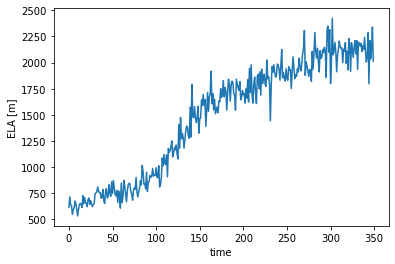

In [3]:
ARCTIC_ela_GrIS_P1_v2 = xr.open_dataset('arctic/ARCTIC_ela_GrIS_yearly_p1_v2.nc')['ELA']
ARCTIC_ela_GrIS_P2_v2 = xr.open_dataset('arctic/ARCTIC_ela_GrIS_yearly_p2_v2.nc')['ELA']
ARCTIC_ela_GrIS_P3_v2 = xr.open_dataset('arctic/ARCTIC_ela_GrIS_yearly_p3_v2.nc')['ELA']
ARCTIC_ela_GrIS_P4_v2 = xr.open_dataset('arctic/ARCTIC_ela_GrIS_yearly_p4_v2.nc')['ELA']
ARCTIC_ela_GrIS_P5_v2 = xr.open_dataset('arctic/ARCTIC_ela_GrIS_yearly_p5_v2.nc')['ELA']
ARCTIC_ela_GrIS_P6_v2 = xr.open_dataset('arctic/ARCTIC_ela_GrIS_yearly_p6_v2.nc')['ELA']
ARCTIC_ela_GrIS_P7_v2 = xr.open_dataset('arctic/ARCTIC_ela_GrIS_yearly_p7_v2.nc')['ELA']

ARCTIC_ela_GrIS_yearly_v2 = xr.concat([ARCTIC_ela_GrIS_P1_v2, ARCTIC_ela_GrIS_P2_v2, ARCTIC_ela_GrIS_P3_v2, ARCTIC_ela_GrIS_P4_v2, ARCTIC_ela_GrIS_P5_v2, ARCTIC_ela_GrIS_P6_v2, ARCTIC_ela_GrIS_P7_v2], dim='time')

ARCTIC_ela_GrIS_yearly_v2.plot();

##### Using length weighted

In [12]:
def Calculate_ELA_ARCTIC_ah_sqrt(phis, smb, mask, yr):

    # Mask the GrIS
    ARCTIC_1pctCO2_4xext_smb_yearly_GrIS = smb[yr,:].where(mask[yr,:]>0)
    ARCTIC_1pctCO2_4xext_PHIS_yearly_GrIS = phis[yr,:].where(mask[yr,:]>0)
    ARCTIC_area_GrIS = ARCTIC_area_coord.where(mask[yr,:]>0)
    ARCTIC_lon_GrIS = ARCTIC_lon.where(mask[yr,:]>0)
    ARCTIC_lat_GrIS = ARCTIC_lat.where(mask[yr,:]>0)
    ARCTIC_lon_corner_GrIS = ARCTIC_scrip.grid_corner_lon.copy() # Note: need copy() here!
    ARCTIC_lat_corner_GrIS = ARCTIC_scrip.grid_corner_lat.copy()
    for i in range(10):
        ARCTIC_lon_corner_GrIS[:,i] = ARCTIC_scrip.grid_corner_lon[:,i].where(mask[yr,:]>0)
        ARCTIC_lat_corner_GrIS[:,i] = ARCTIC_scrip.grid_corner_lat[:,i].where(mask[yr,:]>0)

    # Mask the ablation zone
    ARCTIC_1pctCO2_4xext_smb_yearly_GrIS_abl = ARCTIC_1pctCO2_4xext_smb_yearly_GrIS.where(ARCTIC_1pctCO2_4xext_smb_yearly_GrIS.values<0)
    ARCTIC_1pctCO2_4xext_PHIS_yearly_GrIS_abl = ARCTIC_1pctCO2_4xext_PHIS_yearly_GrIS.where(ARCTIC_1pctCO2_4xext_smb_yearly_GrIS.values<0) # Note: PHIS has dim 'ncol', not 'lndgrid' in smb
    ARCTIC_area_GrIS_abl = ARCTIC_area_GrIS.where(ARCTIC_1pctCO2_4xext_smb_yearly_GrIS.values<0)
    ARCTIC_lon_GrIS_abl = ARCTIC_lon_GrIS.where(ARCTIC_1pctCO2_4xext_smb_yearly_GrIS.values<0)
    ARCTIC_lat_GrIS_abl = ARCTIC_lat_GrIS.where(ARCTIC_1pctCO2_4xext_smb_yearly_GrIS.values<0)
    ARCTIC_lon_corner_GrIS_abl = ARCTIC_lon_corner_GrIS.copy()
    ARCTIC_lat_corner_GrIS_abl = ARCTIC_lat_corner_GrIS.copy()
    for i in range(10):
        ARCTIC_lon_corner_GrIS_abl[:,i] = ARCTIC_lon_corner_GrIS[:,i].where(ARCTIC_1pctCO2_4xext_smb_yearly_GrIS.values<0)
        ARCTIC_lat_corner_GrIS_abl[:,i] = ARCTIC_lat_corner_GrIS[:,i].where(ARCTIC_1pctCO2_4xext_smb_yearly_GrIS.values<0)

    # Mask the accumulation zone
    ARCTIC_1pctCO2_4xext_smb_yearly_GrIS_acc = ARCTIC_1pctCO2_4xext_smb_yearly_GrIS.where(ARCTIC_1pctCO2_4xext_smb_yearly_GrIS.values>=0)
    ARCTIC_1pctCO2_4xext_PHIS_yearly_GrIS_acc = ARCTIC_1pctCO2_4xext_PHIS_yearly_GrIS.where(ARCTIC_1pctCO2_4xext_smb_yearly_GrIS.values>=0)
    ARCTIC_area_GrIS_acc = ARCTIC_area_GrIS.where(ARCTIC_1pctCO2_4xext_smb_yearly_GrIS.values>=0)
    ARCTIC_lon_GrIS_acc = ARCTIC_lon_GrIS.where(ARCTIC_1pctCO2_4xext_smb_yearly_GrIS.values>=0)
    ARCTIC_lat_GrIS_acc = ARCTIC_lat_GrIS.where(ARCTIC_1pctCO2_4xext_smb_yearly_GrIS.values>=0)
    ARCTIC_lon_corner_GrIS_acc = ARCTIC_lon_corner_GrIS.copy()
    ARCTIC_lat_corner_GrIS_acc = ARCTIC_lat_corner_GrIS.copy()
    for i in range(10):
        ARCTIC_lon_corner_GrIS_acc[:,i] = ARCTIC_lon_corner_GrIS[:,i].where(ARCTIC_1pctCO2_4xext_smb_yearly_GrIS.values>=0)
        ARCTIC_lat_corner_GrIS_acc[:,i] = ARCTIC_lat_corner_GrIS[:,i].where(ARCTIC_1pctCO2_4xext_smb_yearly_GrIS.values>=0)

    # Remove nan values
    # ablation zone
    ARCTIC_1pctCO2_4xext_smb_yearly_GrIS_abl_dn = ARCTIC_1pctCO2_4xext_smb_yearly_GrIS_abl.dropna(dim='lndgrid')
    ARCTIC_1pctCO2_4xext_PHIS_yearly_GrIS_abl_dn = ARCTIC_1pctCO2_4xext_PHIS_yearly_GrIS_abl.dropna(dim='ncol')
    ARCTIC_area_GrIS_abl_dn = ARCTIC_area_GrIS_abl.dropna(dim='ncol')
    ARCTIC_lon_GrIS_abl_dn = ARCTIC_lon_GrIS_abl.dropna(dim='ncol')
    ARCTIC_lat_GrIS_abl_dn = ARCTIC_lat_GrIS_abl.dropna(dim='ncol')
    ARCTIC_lon_corner_GrIS_abl_dn = ARCTIC_lon_corner_GrIS_abl.dropna(dim='grid_size')
    ARCTIC_lat_corner_GrIS_abl_dn = ARCTIC_lat_corner_GrIS_abl.dropna(dim='grid_size')
    ARCTIC_area_GrIS_abl_dn = ARCTIC_area_GrIS_abl.dropna(dim='ncol')
    num_ablation_grid = len(ARCTIC_area_GrIS_abl_dn)
    # accumulation zone
    ARCTIC_1pctCO2_4xext_smb_yearly_GrIS_acc_dn = ARCTIC_1pctCO2_4xext_smb_yearly_GrIS_acc.dropna(dim='lndgrid')
    ARCTIC_1pctCO2_4xext_PHIS_yearly_GrIS_acc_dn = ARCTIC_1pctCO2_4xext_PHIS_yearly_GrIS_acc.dropna(dim='ncol')
    ARCTIC_lon_GrIS_acc_dn = ARCTIC_lon_GrIS_acc.dropna(dim='ncol')
    ARCTIC_lat_GrIS_acc_dn = ARCTIC_lat_GrIS_acc.dropna(dim='ncol')
    ARCTIC_lon_corner_GrIS_acc_dn = ARCTIC_lon_corner_GrIS_acc.dropna(dim='grid_size')
    ARCTIC_lat_corner_GrIS_acc_dn = ARCTIC_lat_corner_GrIS_acc.dropna(dim='grid_size')
    ARCTIC_area_GrIS_acc_dn = ARCTIC_area_GrIS_acc.dropna(dim='ncol')
    num_accumulation_grid = len(ARCTIC_area_GrIS_acc_dn)

    # Create new variables
    grid_ELA_elev = []
    length = []

    for i in range(num_ablation_grid):
        # lon, lat of the ablation grid
        lon = ARCTIC_lon_GrIS_abl_dn[i].values
        lat = ARCTIC_lat_GrIS_abl_dn[i].values
        lon_corner = ARCTIC_lon_corner_GrIS_abl_dn[i,:]
        lat_corner = ARCTIC_lat_corner_GrIS_abl_dn[i,:]

        # Check if any of the neighboring four grids has >0 SMB
        for j in range(num_accumulation_grid):
            # limit the looping grids to a small nearby area
            if (abs(ARCTIC_lon_GrIS_acc_dn[j].values - lon) < 1) & (abs(ARCTIC_lat_GrIS_acc_dn[j].values - lat) < 1):
                lon_corner_acc = ARCTIC_lon_corner_GrIS_acc_dn[j,:]
                lat_corner_acc = ARCTIC_lat_corner_GrIS_acc_dn[j,:]

                # Remove duplicated lon,lat pairs
                lonlat_corner = xr.concat([lon_corner, lat_corner], 'new_dim')
                lonlat_corner_uni = np.unique(lonlat_corner, axis=1)
                lonlat_corner_acc = xr.concat([lon_corner_acc, lat_corner_acc], 'new_dim')
                lonlat_corner_acc_uni = np.unique(lonlat_corner_acc, axis=1)

                count = 0
                for k in range(lonlat_corner_uni.shape[1]):
                    if lonlat_corner_uni.T.tolist()[k] in lonlat_corner_acc_uni.T.tolist():
                        count = count + 1

                # Neighboring points
                if count >= 2:
                    grid_smb = ARCTIC_1pctCO2_4xext_smb_yearly_GrIS_abl_dn[i].values
                    grid_elev = ARCTIC_1pctCO2_4xext_PHIS_yearly_GrIS_abl_dn[i].values/g
                    grid_area = ARCTIC_area_GrIS_abl_dn[i].values
                    grid_acc_smb = ARCTIC_1pctCO2_4xext_smb_yearly_GrIS_acc_dn[j].values
                    grid_acc_elev = ARCTIC_1pctCO2_4xext_PHIS_yearly_GrIS_acc_dn[j].values/g
                    grid_acc_area = ARCTIC_area_GrIS_acc_dn[j].values
                    grid_ELA_elev.append(grid_elev + (grid_acc_elev - grid_elev) * ((0 - grid_smb) / (grid_acc_smb - grid_smb)))
                    length.append((sqrt(grid_area) + sqrt(grid_acc_area)) / 2)

    ARCTIC_1pctCO2_4xext_ELA = np.sum(np.array(grid_ELA_elev) * np.array(length)) / np.sum(np.array(length))

    return ARCTIC_1pctCO2_4xext_ELA

In [ ]:
# period 1: year 1-150
ARCTIC_ela_GrIS_p1_ah_sqrt = np.zeros(150)

for i in range(150):
    ARCTIC_ela_GrIS_p1_ah_sqrt[i] = Calculate_ELA_ARCTIC_ah_sqrt(ARCTIC_1pctCO2_4xext_PHIS_yearly, ARCTIC_1pctCO2_4xext_smb_yearly, ARCTIC_GrIS_mask, i)

# Save as netcdf file
df = xr.DataArray(ARCTIC_ela_GrIS_p1_ah_sqrt, dims=['year'], coords=[('year', np.arange(0,150))], name='ELA', attrs=dict(longname='Elevation of equilibrium line', units='m'))
df.to_netcdf(home_dir+'dynamic_GrIS/arctic/ARCTIC_ela_GrIS_yearly_p1_ah_sqrt.nc')

In [ ]:
# period 2: year 151-250
ARCTIC_ela_GrIS_p2_ah_sqrt = np.zeros(100)

for i in range(100):
    ARCTIC_ela_GrIS_p2_ah_sqrt[i] = Calculate_ELA_ARCTIC_ah_sqrt(ARCTIC_1pctCO2_4xext_PHIS_yearly, ARCTIC_1pctCO2_4xext_smb_yearly, ARCTIC_GrIS_mask, i+150)

# Save as netcdf file
df = xr.DataArray(ARCTIC_ela_GrIS_p2_ah_sqrt, dims=['year'], coords=[('year', np.arange(150,250))], name='ELA', attrs=dict(longname='Elevation of equilibrium line', units='m'))
df.to_netcdf(home_dir+'dynamic_GrIS/arctic/ARCTIC_ela_GrIS_yearly_p2_ah_sqrt.nc')

In [ ]:
# period 3: year 251-350
ARCTIC_ela_GrIS_p3_ah_sqrt = np.zeros(100)

for i in range(100):
    ARCTIC_ela_GrIS_p3_ah_sqrt[i] = Calculate_ELA_ARCTIC_ah_sqrt(ARCTIC_1pctCO2_4xext_PHIS_yearly, ARCTIC_1pctCO2_4xext_smb_yearly, ARCTIC_GrIS_mask, i+250)

# Save as netcdf file
df = xr.DataArray(ARCTIC_ela_GrIS_p3_ah_sqrt, dims=['year'], coords=[('year', np.arange(250,350))], name='ELA', attrs=dict(longname='Elevation of equilibrium line', units='m'))
df.to_netcdf(home_dir+'dynamic_GrIS/arctic/ARCTIC_ela_GrIS_yearly_p3_ah_sqrt.nc')

### Plot

#### ELA evolution

In [17]:
## Read ELA time series
# length-weighted
f09_ela_GrIS_ah_sqrt = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_ela_GrIS_yearly_ah_sqrt.nc')['ELA']
f09_nohacks_ela_GrIS_ah_sqrt = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_ela_GrIS_yearly_ah_sqrt.nc')['ELA']

ARCTIC_ela_GrIS_P1_ah_sqrt = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_ela_GrIS_yearly_p1_ah_sqrt.nc')['ELA']
ARCTIC_ela_GrIS_P2_ah_sqrt = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_ela_GrIS_yearly_p2_ah_sqrt.nc')['ELA']
ARCTIC_ela_GrIS_P3_ah_sqrt = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_ela_GrIS_yearly_p3_ah_sqrt.nc')['ELA']
ARCTIC_ela_GrIS_ah_sqrt = xr.concat([ARCTIC_ela_GrIS_P1_ah_sqrt, ARCTIC_ela_GrIS_P2_ah_sqrt, ARCTIC_ela_GrIS_P3_ah_sqrt], dim='year')

ARCTIC2f09_ela_GrIS_ah_sqrt_maskv3 = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC2f09_ela_GrIS_yearly_ah_sqrt_maskv3.nc')['ELA']

In [18]:
## Running mean
f09_ela_GrIS_ah_sqrt_rm = f09_ela_GrIS_ah_sqrt.rolling(time=20, center=True, min_periods=2).mean()
f09_nohacks_ela_GrIS_ah_sqrt_rm = f09_nohacks_ela_GrIS_ah_sqrt.rolling(time=20, center=True, min_periods=2).mean()
ARCTIC_ela_GrIS_ah_sqrt_rm = ARCTIC_ela_GrIS_ah_sqrt.rolling(year=20, center=True, min_periods=2).mean()
ARCTIC2f09_ela_GrIS_ah_sqrt_maskv3_rm = ARCTIC2f09_ela_GrIS_ah_sqrt_maskv3.rolling(time=20, center=True, min_periods=2).mean()

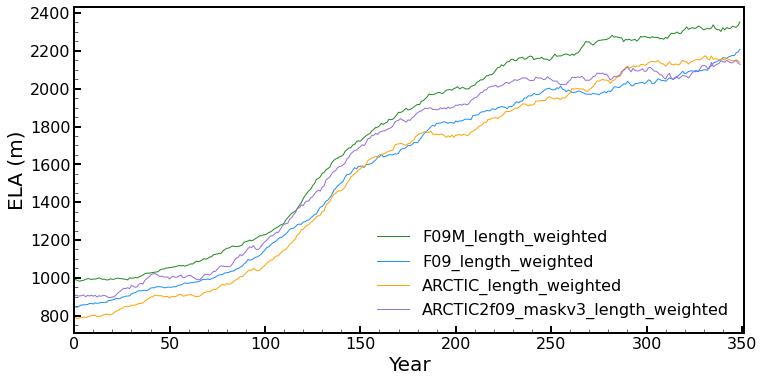

In [32]:
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(1, 1)
plt.rcParams["axes.linewidth"] = 2  # set the value globally

year = np.arange(350)
size_tick = 16
size_label = 20
size_legend = 16
width_line = 1

# -------------------------------------------- ivol --------------------------------------------
ax1 = plt.subplot(gs[0])

ax1.plot(year, f09_ela_GrIS_ah_sqrt_rm, color="forestgreen", linewidth=width_line, linestyle="-", label="F09M_length_weighted")
ax1.plot(year, f09_nohacks_ela_GrIS_ah_sqrt_rm, color="dodgerblue", linewidth=width_line, linestyle="-", label="F09_length_weighted")
ax1.plot(year, ARCTIC_ela_GrIS_ah_sqrt_rm, color="orange", linewidth=width_line, linestyle="-", label="ARCTIC_length_weighted")
ax1.plot(year, ARCTIC2f09_ela_GrIS_ah_sqrt_maskv3_rm, color="mediumpurple", linewidth=width_line, linestyle="-", label="ARCTIC2f09_maskv3_length_weighted")

ax1.legend(loc="best", frameon=False, prop={"size": size_legend}, ncol=1)

ax1.set_xlim([0, 351])
ax1.set_xlabel("Year", fontsize=size_label)
ax1.set_ylabel("ELA (m)", fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which="major", length=7, width=2, direction="in")
ax1.tick_params(which="minor", length=4, direction="in")
ax1.tick_params(labelsize=size_tick)

plt.subplots_adjust(wspace=0.43, hspace=0.23)
plt.savefig(
    home_dir + "dynamic_GrIS/github/plot/tseries_ELA_ah_sqrt.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="w",
    transparent=False,
)  #

#### Ablation area evolution + ELA vs ablation area

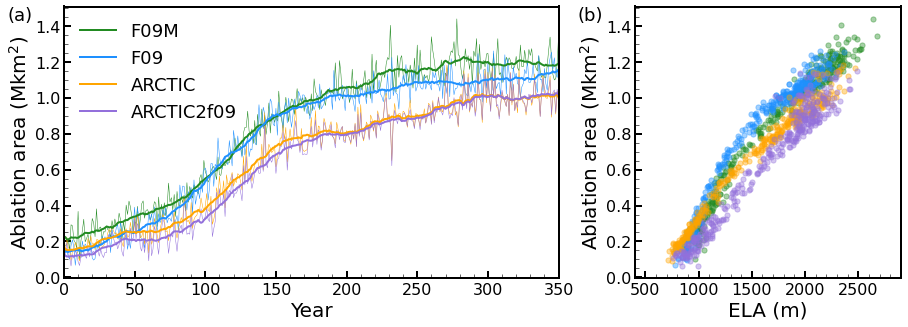

In [30]:
# length weighted algorithm
fig = plt.figure(figsize = (15,5))
gs=GridSpec(5,15)
plt.rcParams['axes.linewidth'] = 2 #set the value globally

size_tick = 16
size_label = 20
size_legend = 18
size_text = 18
#width_line = 2
size_marker = 27

year = np.arange(1,351)

#-------------------------------------------- Ablation area --------------------------------------------
ax1 = plt.subplot(gs[0:5,0:9])

ax1.plot(year, f09_int_1pctCO2_4xext_GrIS_ablation_area/1e12, color='forestgreen', linewidth = 0.5)
ax1.plot(year, f09_nohacks_int_1pctCO2_4xext_GrIS_ablation_area/1e12, color='dodgerblue', linewidth = 0.5)
ax1.plot(year, ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area/1e12, color='orange', linewidth = 0.5)
ax1.plot(year, ARCTIC2f09_int_1pctCO2_4xext_GrIS_ablation_area_maskv3/1e12, color='mediumpurple', linewidth = 0.5)

ax1.plot(year, f09_int_1pctCO2_4xext_GrIS_ablation_area_rm/1e12, color='forestgreen', linewidth = 2, label='F09M')
ax1.plot(year, f09_nohacks_int_1pctCO2_4xext_GrIS_ablation_area_rm/1e12, color='dodgerblue', linewidth = 2, label='F09')
ax1.plot(year, ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area_rm/1e12, color='orange', linewidth = 2, label='ARCTIC')
ax1.plot(year, ARCTIC2f09_int_1pctCO2_4xext_GrIS_ablation_area_maskv3_rm/1e12, color='mediumpurple', linewidth = 2, label='ARCTIC2f09')

ax1.set_xlim([0, 350])
ax1.set_xlabel('Year', fontsize=size_label)
ax1.set_ylabel('Ablation area (M$\mathregular{km^{2}}$)', fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='major', length=7, width=2, direction='in')
ax1.tick_params(which='minor', length=4, direction='in')
ax1.tick_params(labelsize=size_tick)
plt.text(-40, 1.43, '(a)', fontsize=size_text)

ax1.legend(loc = 'best', frameon = False, prop={'size':size_legend}, ncol=1)

#-------------------------------------------- ELA-Ablation area --------------------------------------------
ax3 = plt.subplot(gs[0:5,10:15])

ax3.scatter(f09_ela_GrIS_ah_sqrt, f09_int_1pctCO2_4xext_GrIS_ablation_area/1e12, color='forestgreen', s=size_marker, alpha=0.4, label='F09M');
ax3.scatter(f09_nohacks_ela_GrIS_ah_sqrt, f09_nohacks_int_1pctCO2_4xext_GrIS_ablation_area/1e12, color='dodgerblue', s=size_marker, alpha=0.4, label='F09');
ax3.scatter(ARCTIC_ela_GrIS_ah_sqrt, ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area/1e12, color='orange', s=size_marker, alpha=0.4, label='ARCTIC');
ax3.scatter(ARCTIC2f09_ela_GrIS_ah_sqrt_maskv3, ARCTIC2f09_int_1pctCO2_4xext_GrIS_ablation_area_maskv3/1e12, color='mediumpurple', s=size_marker, alpha=0.4, label='ARCTIC2f09');

ax3.set_xlim([400, 2900])
ax3.set_xlabel('ELA (m)', fontsize=size_label)
ax3.set_ylabel('Ablation area (M$\mathregular{km^{2}}$)', fontsize=size_label)
ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_minor_locator(AutoMinorLocator())
ax3.tick_params(which='major', length=7, width=2, direction='in')
ax3.tick_params(which='minor', length=4, direction='in')
ax3.tick_params(labelsize=size_tick)
plt.text(-140, 1.43, '(b)', fontsize=size_text)


plt.subplots_adjust(wspace=.5, hspace=1.)
plt.savefig(home_dir+'dynamic_GrIS/github/plot/tseries_ablation_area_scatter_ELA_ablation_area_ah_sqrt.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)